In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# FastVit model

In [2]:
# FastViT for PyTorch
#
# Original implementation and weights from https://github.com/apple/ml-fastvit
#
# For licensing see accompanying LICENSE file at https://github.com/apple/ml-fastvit/tree/main
# Original work is copyright (C) 2023 Apple Inc. All Rights Reserved.
#
import os
from functools import partial
from typing import Tuple, Optional, Union

import torch
import torch.nn as nn

import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers import DropPath, trunc_normal_, create_conv2d, ConvNormAct, SqueezeExcite, use_fused_attn, \
    ClassifierHead
from timm.models import build_model_with_cfg, checkpoint_seq,register_model, generate_default_cfgs
#from ._builder import build_model_with_cfg,
#from ._manipulate import checkpoint_seq
#from ._registry import register_model, generate_default_cfgs


def num_groups(group_size, channels):
    if not group_size:  # 0 or None
        return 1  # normal conv with 1 group
    else:
        # NOTE group_size == 1 -> depthwise conv
        assert channels % group_size == 0
        return channels // group_size


class MobileOneBlock(nn.Module):
    """MobileOne building block.

    This block has a multi-branched architecture at train-time
    and plain-CNN style architecture at inference time
    For more details, please refer to our paper:
    `An Improved One millisecond Mobile Backbone` -
    https://arxiv.org/pdf/2206.04040.pdf
    """

    def __init__(
        self,
        in_chs: int,
        out_chs: int,
        kernel_size: int,
        stride: int = 1,
        dilation: int = 1,
        group_size: int = 0,
        inference_mode: bool = False,
        use_se: bool = False,
        use_act: bool = True,
        use_scale_branch: bool = True,
        num_conv_branches: int = 1,
        act_layer: nn.Module = nn.GELU,
    ) -> None:
        """Construct a MobileOneBlock module.

        Args:
            in_chs: Number of channels in the input.
            out_chs: Number of channels produced by the block.
            kernel_size: Size of the convolution kernel.
            stride: Stride size.
            dilation: Kernel dilation factor.
            group_size: Convolution group size.
            inference_mode: If True, instantiates model in inference mode.
            use_se: Whether to use SE-ReLU activations.
            use_act: Whether to use activation. Default: ``True``
            use_scale_branch: Whether to use scale branch. Default: ``True``
            num_conv_branches: Number of linear conv branches.
        """
        super(MobileOneBlock, self).__init__()
        self.inference_mode = inference_mode
        self.groups = num_groups(group_size, in_chs)
        self.stride = stride
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.in_chs = in_chs
        self.out_chs = out_chs
        self.num_conv_branches = num_conv_branches

        # Check if SE-ReLU is requested
        self.se = SqueezeExcite(out_chs, rd_divisor=1) if use_se else nn.Identity()

        if inference_mode:
            self.reparam_conv = create_conv2d(
                in_chs,
                out_chs,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                groups=self.groups,
                bias=True,
            )
        else:
            # Re-parameterizable skip connection
            self.reparam_conv = None

            self.identity = (
                nn.BatchNorm2d(num_features=in_chs)
                if out_chs == in_chs and stride == 1
                else None
            )

            # Re-parameterizable conv branches
            if num_conv_branches > 0:
                self.conv_kxk = nn.ModuleList([
                    ConvNormAct(
                        self.in_chs,
                        self.out_chs,
                        kernel_size=kernel_size,
                        stride=self.stride,
                        groups=self.groups,
                        apply_act=False,
                    ) for _ in range(self.num_conv_branches)
                ])
            else:
                self.conv_kxk = None

            # Re-parameterizable scale branch
            self.conv_scale = None
            if kernel_size > 1 and use_scale_branch:
                self.conv_scale = ConvNormAct(
                    self.in_chs,
                    self.out_chs,
                    kernel_size=1,
                    stride=self.stride,
                    groups=self.groups,
                    apply_act=False
                )

        self.act = act_layer() if use_act else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply forward pass."""
        # Inference mode forward pass.
        if self.reparam_conv is not None:
            return self.act(self.se(self.reparam_conv(x)))

        # Multi-branched train-time forward pass.
        # Identity branch output
        identity_out = 0
        if self.identity is not None:
            identity_out = self.identity(x)

        # Scale branch output
        scale_out = 0
        if self.conv_scale is not None:
            scale_out = self.conv_scale(x)

        # Other kxk conv branches
        out = scale_out + identity_out
        if self.conv_kxk is not None:
            for rc in self.conv_kxk:
                out += rc(x)

        return self.act(self.se(out))

    def reparameterize(self):
        """Following works like `RepVGG: Making VGG-style ConvNets Great Again` -
        https://arxiv.org/pdf/2101.03697.pdf. We re-parameterize multi-branched
        architecture used at training time to obtain a plain CNN-like structure
        for inference.
        """
        if self.reparam_conv is not None:
            return

        kernel, bias = self._get_kernel_bias()
        self.reparam_conv = create_conv2d(
            in_channels=self.in_chs,
            out_channels=self.out_chs,
            kernel_size=self.kernel_size,
            stride=self.stride,
            dilation=self.dilation,
            groups=self.groups,
            bias=True,
        )
        self.reparam_conv.weight.data = kernel
        self.reparam_conv.bias.data = bias

        # Delete un-used branches
        for name, para in self.named_parameters():
            if 'reparam_conv' in name:
                continue
            para.detach_()

        self.__delattr__("conv_kxk")
        self.__delattr__("conv_scale")
        if hasattr(self, "identity"):
            self.__delattr__("identity")

        self.inference_mode = True

    def _get_kernel_bias(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Method to obtain re-parameterized kernel and bias.
        Reference: https://github.com/DingXiaoH/RepVGG/blob/main/repvgg.py#L83

        Returns:
            Tuple of (kernel, bias) after fusing branches.
        """
        # get weights and bias of scale branch
        kernel_scale = 0
        bias_scale = 0
        if self.conv_scale is not None:
            kernel_scale, bias_scale = self._fuse_bn_tensor(self.conv_scale)
            # Pad scale branch kernel to match conv branch kernel size.
            pad = self.kernel_size // 2
            kernel_scale = torch.nn.functional.pad(kernel_scale, [pad, pad, pad, pad])

        # get weights and bias of skip branch
        kernel_identity = 0
        bias_identity = 0
        if self.identity is not None:
            kernel_identity, bias_identity = self._fuse_bn_tensor(self.identity)

        # get weights and bias of conv branches
        kernel_conv = 0
        bias_conv = 0
        if self.conv_kxk is not None:
            for ix in range(self.num_conv_branches):
                _kernel, _bias = self._fuse_bn_tensor(self.conv_kxk[ix])
                kernel_conv += _kernel
                bias_conv += _bias

        kernel_final = kernel_conv + kernel_scale + kernel_identity
        bias_final = bias_conv + bias_scale + bias_identity
        return kernel_final, bias_final

    def _fuse_bn_tensor(
        self, branch: Union[nn.Sequential, nn.BatchNorm2d]
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Method to fuse batchnorm layer with preceeding conv layer.
        Reference: https://github.com/DingXiaoH/RepVGG/blob/main/repvgg.py#L95

        Args:
            branch: Sequence of ops to be fused.

        Returns:
            Tuple of (kernel, bias) after fusing batchnorm.
        """
        if isinstance(branch, ConvNormAct):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, "id_tensor"):
                input_dim = self.in_chs // self.groups
                kernel_value = torch.zeros(
                    (self.in_chs, input_dim, self.kernel_size, self.kernel_size),
                    dtype=branch.weight.dtype,
                    device=branch.weight.device,
                )
                for i in range(self.in_chs):
                    kernel_value[
                        i, i % input_dim, self.kernel_size // 2, self.kernel_size // 2
                    ] = 1
                self.id_tensor = kernel_value
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std


class ReparamLargeKernelConv(nn.Module):
    """Building Block of RepLKNet

    This class defines overparameterized large kernel conv block
    introduced in `RepLKNet <https://arxiv.org/abs/2203.06717>`_

    Reference: https://github.com/DingXiaoH/RepLKNet-pytorch
    """

    def __init__(
        self,
        in_chs: int,
        out_chs: int,
        kernel_size: int,
        stride: int,
        group_size: int,
        small_kernel: Optional[int] = None,
        inference_mode: bool = False,
        act_layer: Optional[nn.Module] = None,
    ) -> None:
        """Construct a ReparamLargeKernelConv module.

        Args:
            in_chs: Number of input channels.
            out_chs: Number of output channels.
            kernel_size: Kernel size of the large kernel conv branch.
            stride: Stride size. Default: 1
            group_size: Group size. Default: 1
            small_kernel: Kernel size of small kernel conv branch.
            inference_mode: If True, instantiates model in inference mode. Default: ``False``
            act_layer: Activation module. Default: ``nn.GELU``
        """
        super(ReparamLargeKernelConv, self).__init__()
        self.stride = stride
        self.groups = num_groups(group_size, in_chs)
        self.in_chs = in_chs
        self.out_chs = out_chs

        self.kernel_size = kernel_size
        self.small_kernel = small_kernel
        if inference_mode:
            self.reparam_conv = create_conv2d(
                in_chs,
                out_chs,
                kernel_size=kernel_size,
                stride=stride,
                dilation=1,
                groups=self.groups,
                bias=True,
            )
        else:
            self.reparam_conv = None
            self.large_conv = ConvNormAct(
                in_chs,
                out_chs,
                kernel_size=kernel_size,
                stride=self.stride,
                groups=self.groups,
                apply_act=False,
            )
            if small_kernel is not None:
                assert (
                    small_kernel <= kernel_size
                ), "The kernel size for re-param cannot be larger than the large kernel!"
                self.small_conv = ConvNormAct(
                    in_chs,
                    out_chs,
                    kernel_size=small_kernel,
                    stride=self.stride,
                    groups=self.groups,
                    apply_act=False,
                )
        # FIXME output of this act was not used in original impl, likely due to bug
        self.act = act_layer() if act_layer is not None else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.reparam_conv is not None:
            out = self.reparam_conv(x)
        else:
            out = self.large_conv(x)
            if self.small_conv is not None:
                out = out + self.small_conv(x)
        out = self.act(out)
        return out

    def get_kernel_bias(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Method to obtain re-parameterized kernel and bias.
        Reference: https://github.com/DingXiaoH/RepLKNet-pytorch

        Returns:
            Tuple of (kernel, bias) after fusing branches.
        """
        eq_k, eq_b = self._fuse_bn(self.large_conv.conv, self.large_conv.bn)
        if hasattr(self, "small_conv"):
            small_k, small_b = self._fuse_bn(self.small_conv.conv, self.small_conv.bn)
            eq_b += small_b
            eq_k += nn.functional.pad(
                small_k, [(self.kernel_size - self.small_kernel) // 2] * 4
            )
        return eq_k, eq_b

    def reparameterize(self) -> None:
        """
        Following works like `RepVGG: Making VGG-style ConvNets Great Again` -
        https://arxiv.org/pdf/2101.03697.pdf. We re-parameterize multi-branched
        architecture used at training time to obtain a plain CNN-like structure
        for inference.
        """
        eq_k, eq_b = self.get_kernel_bias()
        self.reparam_conv = create_conv2d(
            self.in_chs,
            self.out_chs,
            kernel_size=self.kernel_size,
            stride=self.stride,
            groups=self.groups,
            bias=True,
        )

        self.reparam_conv.weight.data = eq_k
        self.reparam_conv.bias.data = eq_b
        self.__delattr__("large_conv")
        if hasattr(self, "small_conv"):
            self.__delattr__("small_conv")

    @staticmethod
    def _fuse_bn(
        conv: torch.Tensor, bn: nn.BatchNorm2d
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Method to fuse batchnorm layer with conv layer.

        Args:
            conv: Convolutional kernel weights.
            bn: Batchnorm 2d layer.

        Returns:
            Tuple of (kernel, bias) after fusing batchnorm.
        """
        kernel = conv.weight
        running_mean = bn.running_mean
        running_var = bn.running_var
        gamma = bn.weight
        beta = bn.bias
        eps = bn.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std


def convolutional_stem(
        in_chs: int,
        out_chs: int,
        act_layer: nn.Module = nn.GELU,
        inference_mode: bool = False
) -> nn.Sequential:
    """Build convolutional stem with MobileOne blocks.

    Args:
        in_chs: Number of input channels.
        out_chs: Number of output channels.
        inference_mode: Flag to instantiate model in inference mode. Default: ``False``

    Returns:
        nn.Sequential object with stem elements.
    """
    return nn.Sequential(
        MobileOneBlock(
            in_chs=in_chs,
            out_chs=out_chs,
            kernel_size=3,
            stride=2,
            act_layer=act_layer,
            inference_mode=inference_mode,
        ),
        MobileOneBlock(
            in_chs=out_chs,
            out_chs=out_chs,
            kernel_size=3,
            stride=2,
            group_size=1,
            act_layer=act_layer,
            inference_mode=inference_mode,
        ),
        MobileOneBlock(
            in_chs=out_chs,
            out_chs=out_chs,
            kernel_size=1,
            stride=1,
            act_layer=act_layer,
            inference_mode=inference_mode,
        ),
    )


class Attention(nn.Module):
    """Multi-headed Self Attention module.

    Source modified from:
    https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    """
    fused_attn: torch.jit.Final[bool]

    def __init__(
        self,
        dim: int,
        head_dim: int = 32,
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """Build MHSA module that can handle 3D or 4D input tensors.

        Args:
            dim: Number of embedding dimensions.
            head_dim: Number of hidden dimensions per head. Default: ``32``
            qkv_bias: Use bias or not. Default: ``False``
            attn_drop: Dropout rate for attention tensor.
            proj_drop: Dropout rate for projection tensor.
        """
        super().__init__()
        assert dim % head_dim == 0, "dim should be divisible by head_dim"
        self.head_dim = head_dim
        self.num_heads = dim // head_dim
        self.scale = head_dim ** -0.5
        self.fused_attn = use_fused_attn()

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        N = H * W
        x = x.flatten(2).transpose(-2, -1)  # (B, N, C)
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, self.head_dim)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv.unbind(0)  # make torchscript happy (cannot use tensor as tuple)

        if self.fused_attn:
            x = torch.nn.functional.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_drop.p if self.training else 0.,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        x = x.transpose(-2, -1).reshape(B, C, H, W)

        return x


class PatchEmbed(nn.Module):
    """Convolutional patch embedding layer."""

    def __init__(
        self,
        patch_size: int,
        stride: int,
        in_chs: int,
        embed_dim: int,
        act_layer: nn.Module = nn.GELU,
        lkc_use_act: bool = False,
        inference_mode: bool = False,
    ) -> None:
        """Build patch embedding layer.

        Args:
            patch_size: Patch size for embedding computation.
            stride: Stride for convolutional embedding layer.
            in_chs: Number of channels of input tensor.
            embed_dim: Number of embedding dimensions.
            inference_mode: Flag to instantiate model in inference mode. Default: ``False``
        """
        super().__init__()
        self.proj = nn.Sequential(
            ReparamLargeKernelConv(
                in_chs=in_chs,
                out_chs=embed_dim,
                kernel_size=patch_size,
                stride=stride,
                group_size=1,
                small_kernel=3,
                inference_mode=inference_mode,
                act_layer=act_layer if lkc_use_act else None,  # NOTE original weights didn't use this act
            ),
            MobileOneBlock(
                in_chs=embed_dim,
                out_chs=embed_dim,
                kernel_size=1,
                stride=1,
                act_layer=act_layer,
                inference_mode=inference_mode,
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        return x


class LayerScale2d(nn.Module):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(init_values * torch.ones(dim, 1, 1))

    def forward(self, x):
        return x.mul_(self.gamma) if self.inplace else x * self.gamma


class RepMixer(nn.Module):
    """Reparameterizable token mixer.

    For more details, please refer to our paper:
    `FastViT: A Fast Hybrid Vision Transformer using Structural Reparameterization <https://arxiv.org/pdf/2303.14189.pdf>`_
    """

    def __init__(
        self,
        dim,
        kernel_size=3,
        layer_scale_init_value=1e-5,
        inference_mode: bool = False,
    ):
        """Build RepMixer Module.

        Args:
            dim: Input feature map dimension. :math:`C_{in}` from an expected input of size :math:`(B, C_{in}, H, W)`.
            kernel_size: Kernel size for spatial mixing. Default: 3
            layer_scale_init_value: Initial value for layer scale. Default: 1e-5
            inference_mode: If True, instantiates model in inference mode. Default: ``False``
        """
        super().__init__()
        self.dim = dim
        self.kernel_size = kernel_size
        self.inference_mode = inference_mode

        if inference_mode:
            self.reparam_conv = nn.Conv2d(
                self.dim,
                self.dim,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.kernel_size // 2,
                groups=self.dim,
                bias=True,
            )
        else:
            self.reparam_conv = None
            self.norm = MobileOneBlock(
                dim,
                dim,
                kernel_size,
                group_size=1,
                use_act=False,
                use_scale_branch=False,
                num_conv_branches=0,
            )
            self.mixer = MobileOneBlock(
                dim,
                dim,
                kernel_size,
                group_size=1,
                use_act=False,
            )
            if layer_scale_init_value is not None:
                self.layer_scale = LayerScale2d(dim, layer_scale_init_value)
            else:
                self.layer_scale = nn.Identity

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.reparam_conv is not None:
            x = self.reparam_conv(x)
        else:
            x = x + self.layer_scale(self.mixer(x) - self.norm(x))
        return x

    def reparameterize(self) -> None:
        """Reparameterize mixer and norm into a single
        convolutional layer for efficient inference.
        """
        if self.inference_mode:
            return

        self.mixer.reparameterize()
        self.norm.reparameterize()

        if isinstance(self.layer_scale, LayerScale2d):
            w = self.mixer.id_tensor + self.layer_scale.gamma.unsqueeze(-1) * (
                self.mixer.reparam_conv.weight - self.norm.reparam_conv.weight
            )
            b = torch.squeeze(self.layer_scale.gamma) * (
                self.mixer.reparam_conv.bias - self.norm.reparam_conv.bias
            )
        else:
            w = (
                self.mixer.id_tensor
                + self.mixer.reparam_conv.weight
                - self.norm.reparam_conv.weight
            )
            b = self.mixer.reparam_conv.bias - self.norm.reparam_conv.bias

        self.reparam_conv = create_conv2d(
            self.dim,
            self.dim,
            kernel_size=self.kernel_size,
            stride=1,
            groups=self.dim,
            bias=True,
        )
        self.reparam_conv.weight.data = w
        self.reparam_conv.bias.data = b

        for name, para in self.named_parameters():
            if 'reparam_conv' in name:
                continue
            para.detach_()
        self.__delattr__("mixer")
        self.__delattr__("norm")
        self.__delattr__("layer_scale")


class ConvMlp(nn.Module):
    """Convolutional FFN Module."""

    def __init__(
        self,
        in_chs: int,
        hidden_channels: Optional[int] = None,
        out_chs: Optional[int] = None,
        act_layer: nn.Module = nn.GELU,
        drop: float = 0.0,
    ) -> None:
        """Build convolutional FFN module.

        Args:
            in_chs: Number of input channels.
            hidden_channels: Number of channels after expansion. Default: None
            out_chs: Number of output channels. Default: None
            act_layer: Activation layer. Default: ``GELU``
            drop: Dropout rate. Default: ``0.0``.
        """
        super().__init__()
        out_chs = out_chs or in_chs
        hidden_channels = hidden_channels or in_chs
        self.conv = ConvNormAct(
            in_chs,
            out_chs,
            kernel_size=7,
            groups=in_chs,
            apply_act=False,
        )
        self.fc1 = nn.Conv2d(in_chs, hidden_channels, kernel_size=1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_channels, out_chs, kernel_size=1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module) -> None:
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class RepConditionalPosEnc(nn.Module):
    """Implementation of conditional positional encoding.

    For more details refer to paper:
    `Conditional Positional Encodings for Vision Transformers <https://arxiv.org/pdf/2102.10882.pdf>`_

    In our implementation, we can reparameterize this module to eliminate a skip connection.
    """

    def __init__(
        self,
        dim: int,
        dim_out: Optional[int] = None,
        spatial_shape: Union[int, Tuple[int, int]] = (7, 7),
        inference_mode=False,
    ) -> None:
        """Build reparameterizable conditional positional encoding

        Args:
            dim: Number of input channels.
            dim_out: Number of embedding dimensions. Default: 768
            spatial_shape: Spatial shape of kernel for positional encoding. Default: (7, 7)
            inference_mode: Flag to instantiate block in inference mode. Default: ``False``
        """
        super(RepConditionalPosEnc, self).__init__()
        if isinstance(spatial_shape, int):
            spatial_shape = tuple([spatial_shape] * 2)
        assert isinstance(spatial_shape, Tuple), (
            f'"spatial_shape" must by a sequence or int, '
            f"get {type(spatial_shape)} instead."
        )
        assert len(spatial_shape) == 2, (
            f'Length of "spatial_shape" should be 2, '
            f"got {len(spatial_shape)} instead."
        )

        self.spatial_shape = spatial_shape
        self.dim = dim
        self.dim_out = dim_out or dim
        self.groups = dim

        if inference_mode:
            self.reparam_conv = nn.Conv2d(
                self.dim,
                self.dim_out,
                kernel_size=self.spatial_shape,
                stride=1,
                padding=spatial_shape[0] // 2,
                groups=self.groups,
                bias=True,
            )
        else:
            self.reparam_conv = None
            self.pos_enc = nn.Conv2d(
                self.dim,
                self.dim_out,
                spatial_shape,
                1,
                int(spatial_shape[0] // 2),
                groups=self.groups,
                bias=True,
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.reparam_conv is not None:
            x = self.reparam_conv(x)
        else:
            x = self.pos_enc(x) + x
        return x

    def reparameterize(self) -> None:
        # Build equivalent Id tensor
        input_dim = self.dim // self.groups
        kernel_value = torch.zeros(
            (
                self.dim,
                input_dim,
                self.spatial_shape[0],
                self.spatial_shape[1],
            ),
            dtype=self.pos_enc.weight.dtype,
            device=self.pos_enc.weight.device,
        )
        for i in range(self.dim):
            kernel_value[
                i,
                i % input_dim,
                self.spatial_shape[0] // 2,
                self.spatial_shape[1] // 2,
            ] = 1
        id_tensor = kernel_value

        # Reparameterize Id tensor and conv
        w_final = id_tensor + self.pos_enc.weight
        b_final = self.pos_enc.bias

        # Introduce reparam conv
        self.reparam_conv = nn.Conv2d(
            self.dim,
            self.dim_out,
            kernel_size=self.spatial_shape,
            stride=1,
            padding=int(self.spatial_shape[0] // 2),
            groups=self.groups,
            bias=True,
        )
        self.reparam_conv.weight.data = w_final
        self.reparam_conv.bias.data = b_final

        for name, para in self.named_parameters():
            if 'reparam_conv' in name:
                continue
            para.detach_()
        self.__delattr__("pos_enc")


class RepMixerBlock(nn.Module):
    """Implementation of Metaformer block with RepMixer as token mixer.

    For more details on Metaformer structure, please refer to:
    `MetaFormer Is Actually What You Need for Vision <https://arxiv.org/pdf/2111.11418.pdf>`_
    """

    def __init__(
        self,
        dim: int,
        kernel_size: int = 3,
        mlp_ratio: float = 4.0,
        act_layer: nn.Module = nn.GELU,
        proj_drop: float = 0.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 1e-5,
        inference_mode: bool = False,
    ):
        """Build RepMixer Block.

        Args:
            dim: Number of embedding dimensions.
            kernel_size: Kernel size for repmixer. Default: 3
            mlp_ratio: MLP expansion ratio. Default: 4.0
            act_layer: Activation layer. Default: ``nn.GELU``
            proj_drop: Dropout rate. Default: 0.0
            drop_path: Drop path rate. Default: 0.0
            layer_scale_init_value: Layer scale value at initialization. Default: 1e-5
            inference_mode: Flag to instantiate block in inference mode. Default: ``False``
        """

        super().__init__()

        self.token_mixer = RepMixer(
            dim,
            kernel_size=kernel_size,
            layer_scale_init_value=layer_scale_init_value,
            inference_mode=inference_mode,
        )

        self.mlp = ConvMlp(
            in_chs=dim,
            hidden_channels=int(dim * mlp_ratio),
            act_layer=act_layer,
            drop=proj_drop,
        )
        if layer_scale_init_value is not None:
            self.layer_scale = LayerScale2d(dim, layer_scale_init_value)
        else:
            self.layer_scale = nn.Identity()
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        x = self.token_mixer(x)
        x = x + self.drop_path(self.layer_scale(self.mlp(x)))
        return x


class AttentionBlock(nn.Module):
    """Implementation of metaformer block with MHSA as token mixer.

    For more details on Metaformer structure, please refer to:
    `MetaFormer Is Actually What You Need for Vision <https://arxiv.org/pdf/2111.11418.pdf>`_
    """

    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        act_layer: nn.Module = nn.GELU,
        norm_layer: nn.Module = nn.BatchNorm2d,
        proj_drop: float = 0.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 1e-5,
    ):
        """Build Attention Block.

        Args:
            dim: Number of embedding dimensions.
            mlp_ratio: MLP expansion ratio. Default: 4.0
            act_layer: Activation layer. Default: ``nn.GELU``
            norm_layer: Normalization layer. Default: ``nn.BatchNorm2d``
            proj_drop: Dropout rate. Default: 0.0
            drop_path: Drop path rate. Default: 0.0
            layer_scale_init_value: Layer scale value at initialization. Default: 1e-5
        """

        super().__init__()

        self.norm = norm_layer(dim)
        self.token_mixer = Attention(dim=dim)
        if layer_scale_init_value is not None:
            self.layer_scale_1 = LayerScale2d(dim, layer_scale_init_value)
        else:
            self.layer_scale_1 = nn.Identity()
        self.drop_path1 = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

        self.mlp = ConvMlp(
            in_chs=dim,
            hidden_channels=int(dim * mlp_ratio),
            act_layer=act_layer,
            drop=proj_drop,
        )
        if layer_scale_init_value is not None:
            self.layer_scale_2 = LayerScale2d(dim, layer_scale_init_value)
        else:
            self.layer_scale_2 = nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.layer_scale_1(self.token_mixer(self.norm(x))))
        x = x + self.drop_path2(self.layer_scale_2(self.mlp(x)))
        return x


class FastVitStage(nn.Module):
    def __init__(
            self,
            dim: int,
            dim_out: int,
            depth: int,
            token_mixer_type: str,
            downsample: bool = True,
            down_patch_size: int = 7,
            down_stride: int = 2,
            pos_emb_layer: Optional[nn.Module] = None,
            kernel_size: int = 3,
            mlp_ratio: float = 4.0,
            act_layer: nn.Module = nn.GELU,
            norm_layer: nn.Module = nn.BatchNorm2d,
            proj_drop_rate: float = 0.0,
            drop_path_rate: float = 0.0,
            layer_scale_init_value: Optional[float] = 1e-5,
            lkc_use_act=False,
            inference_mode=False,
    ):
        """FastViT stage.

        Args:
            dim: Number of embedding dimensions.
            depth: Number of blocks in stage
            token_mixer_type: Token mixer type.
            kernel_size: Kernel size for repmixer.
            mlp_ratio: MLP expansion ratio.
            act_layer: Activation layer.
            norm_layer: Normalization layer.
            proj_drop_rate: Dropout rate.
            drop_path_rate: Drop path rate.
            layer_scale_init_value: Layer scale value at initialization.
            inference_mode: Flag to instantiate block in inference mode.
        """
        super().__init__()
        self.grad_checkpointing = False

        if downsample:
            self.downsample = PatchEmbed(
                patch_size=down_patch_size,
                stride=down_stride,
                in_chs=dim,
                embed_dim=dim_out,
                act_layer=act_layer,
                lkc_use_act=lkc_use_act,
                inference_mode=inference_mode,
            )
        else:
            assert dim == dim_out
            self.downsample = nn.Identity()

        if pos_emb_layer is not None:
            self.pos_emb = pos_emb_layer(dim_out, inference_mode=inference_mode)
        else:
            self.pos_emb = nn.Identity()

        blocks = []
        for block_idx in range(depth):
            if token_mixer_type == "repmixer":
                blocks.append(RepMixerBlock(
                    dim_out,
                    kernel_size=kernel_size,
                    mlp_ratio=mlp_ratio,
                    act_layer=act_layer,
                    proj_drop=proj_drop_rate,
                    drop_path=drop_path_rate[block_idx],
                    layer_scale_init_value=layer_scale_init_value,
                    inference_mode=inference_mode,
                ))
            elif token_mixer_type == "attention":
                blocks.append(AttentionBlock(
                    dim_out,
                    mlp_ratio=mlp_ratio,
                    act_layer=act_layer,
                    norm_layer=norm_layer,
                    proj_drop=proj_drop_rate,
                    drop_path=drop_path_rate[block_idx],
                    layer_scale_init_value=layer_scale_init_value,
                ))
            else:
                raise ValueError(
                    "Token mixer type: {} not supported".format(token_mixer_type)
                )
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        x = self.downsample(x)
        x = self.pos_emb(x)
        if self.grad_checkpointing and not torch.jit.is_scripting():
            x = checkpoint_seq(self.blocks, x)
        else:
            x = self.blocks(x)
        return x


class FastVit(nn.Module):
    fork_feat: torch.jit.Final[bool]

    """
    This class implements `FastViT architecture <https://arxiv.org/pdf/2303.14189.pdf>`_
    """

    def __init__(
        self,
        in_chans: int = 3,
        layers: Tuple[int, ...] = (2, 2, 6, 2),
        token_mixers: Tuple[str, ...] = ("repmixer", "repmixer", "repmixer", "repmixer"),
        embed_dims: Tuple[int, ...] = (64, 128, 256, 512),
        mlp_ratios: Tuple[float, ...] = (4,) * 4,
        downsamples: Tuple[bool, ...] = (False, True, True, True),
        repmixer_kernel_size: int = 3,
        num_classes: int = 1000,
        pos_embs: Tuple[Optional[nn.Module], ...] = (None,) * 4,
        down_patch_size: int = 7,
        down_stride: int = 2,
        drop_rate: float = 0.0,
        proj_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 1e-5,
        fork_feat: bool = False,
        cls_ratio: float = 2.0,
        global_pool: str = 'avg',
        norm_layer: nn.Module = nn.BatchNorm2d,
        act_layer: nn.Module = nn.GELU,
        lkc_use_act: bool = False,
        inference_mode: bool = False,
    ) -> None:
        super().__init__()
        self.num_classes = 0 if fork_feat else num_classes
        self.fork_feat = fork_feat
        self.global_pool = global_pool
        self.feature_info = []

        # Convolutional stem
        self.stem = convolutional_stem(
            in_chans,
            embed_dims[0],
            act_layer,
            inference_mode,
        )

        # Build the main stages of the network architecture
        prev_dim = embed_dims[0]
        scale = 1
        dpr = [x.tolist() for x in torch.linspace(0, drop_path_rate, sum(layers)).split(layers)]
        stages = []
        for i in range(len(layers)):
            downsample = downsamples[i] or prev_dim != embed_dims[i]
            stage = FastVitStage(
                dim=prev_dim,
                dim_out=embed_dims[i],
                depth=layers[i],
                downsample=downsample,
                down_patch_size=down_patch_size,
                down_stride=down_stride,
                pos_emb_layer=pos_embs[i],
                token_mixer_type=token_mixers[i],
                kernel_size=repmixer_kernel_size,
                mlp_ratio=mlp_ratios[i],
                act_layer=act_layer,
                norm_layer=norm_layer,
                proj_drop_rate=proj_drop_rate,
                drop_path_rate=dpr[i],
                layer_scale_init_value=layer_scale_init_value,
                lkc_use_act=lkc_use_act,
                inference_mode=inference_mode,
            )
            stages.append(stage)
            prev_dim = embed_dims[i]
            if downsample:
                scale *= 2
            self.feature_info += [dict(num_chs=prev_dim, reduction=4 * scale, module=f'stages.{i}')]
        self.stages = nn.Sequential(*stages)
        self.num_features = prev_dim

        # For segmentation and detection, extract intermediate output
        if self.fork_feat:
            # Add a norm layer for each output. self.stages is slightly different than self.network
            # in the original code, the PatchEmbed layer is part of self.stages in this code where
            # it was part of self.network in the original code. So we do not need to skip out indices.
            self.out_indices = [0, 1, 2, 3]
            for i_emb, i_layer in enumerate(self.out_indices):
                if i_emb == 0 and os.environ.get("FORK_LAST3", None):
                    """For RetinaNet, `start_level=1`. The first norm layer will not used.
                    cmd: `FORK_LAST3=1 python -m torch.distributed.launch ...`
                    """
                    layer = nn.Identity()
                else:
                    layer = norm_layer(embed_dims[i_emb])
                layer_name = f"norm{i_layer}"
                self.add_module(layer_name, layer)
        else:
            # Classifier head
            self.num_features = final_features = int(embed_dims[-1] * cls_ratio)
            self.final_conv = MobileOneBlock(
                in_chs=embed_dims[-1],
                out_chs=final_features,
                kernel_size=3,
                stride=1,
                group_size=1,
                inference_mode=inference_mode,
                use_se=True,
                act_layer=act_layer,
                num_conv_branches=1,
            )
            self.head = ClassifierHead(
                final_features,
                num_classes,
                pool_type=global_pool,
                drop_rate=drop_rate,
            )

        self.apply(self._init_weights)

    def _init_weights(self, m: nn.Module) -> None:
        """Init. for classification"""
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return set()

    @torch.jit.ignore
    def group_matcher(self, coarse=False):
        return dict(
            stem=r'^stem',  # stem and embed
            blocks=r'^stages\.(\d+)' if coarse else [
                (r'^stages\.(\d+).downsample', (0,)),
                (r'^stages\.(\d+).pos_emb', (0,)),
                (r'^stages\.(\d+)\.\w+\.(\d+)', None),
            ]
        )

    @torch.jit.ignore
    def set_grad_checkpointing(self, enable=True):
        for s in self.stages:
            s.grad_checkpointing = enable

    @torch.jit.ignore
    def get_classifier(self):
        return self.head.fc

    def reset_classifier(self, num_classes, global_pool=None):
        self.num_classes = num_classes
        self.head.reset(num_classes, global_pool)

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        # input embedding
        x = self.stem(x)
        outs = []
        for idx, block in enumerate(self.stages):
            x = block(x)
            if self.fork_feat:
                if idx in self.out_indices:
                    norm_layer = getattr(self, f"norm{idx}")
                    x_out = norm_layer(x)
                    outs.append(x_out)
        if self.fork_feat:
            # output the features of four stages for dense prediction
            return outs
        x = self.final_conv(x)
        return x

    def forward_head(self, x: torch.Tensor, pre_logits: bool = False):
        return self.head(x, pre_logits=True) if pre_logits else self.head(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)
        if self.fork_feat:
            return x
        x = self.forward_head(x)
        return x


def _cfg(url="", **kwargs):
    return {
        "url": url,
        "num_classes": 1000,
        "input_size": (3, 256, 256),
        "pool_size": (8, 8),
        "crop_pct": 0.9,
        "interpolation": "bicubic",
        "mean": IMAGENET_DEFAULT_MEAN,
        "std": IMAGENET_DEFAULT_STD,
        'first_conv': ('stem.0.conv_kxk.0.conv', 'stem.0.conv_scale.conv'),
        "classifier": "head.fc",
        **kwargs,
    }


default_cfgs = generate_default_cfgs({
    "fastvit_t8.apple_in1k": _cfg(
        hf_hub_id='timm/'),
    "fastvit_t12.apple_in1k": _cfg(
        hf_hub_id='timm/'),

    "fastvit_s12.apple_in1k": _cfg(
        hf_hub_id='timm/'),
    "fastvit_sa12.apple_in1k": _cfg(
        hf_hub_id='timm/'),
    "fastvit_sa24.apple_in1k": _cfg(
        hf_hub_id='timm/'),
    "fastvit_sa36.apple_in1k": _cfg(
        hf_hub_id='timm/'),

    "fastvit_ma36.apple_in1k": _cfg(
        hf_hub_id='timm/',
        crop_pct=0.95
    ),

    "fastvit_t8.apple_dist_in1k": _cfg(
        hf_hub_id='timm/'),
    "fastvit_t12.apple_dist_in1k": _cfg(
        hf_hub_id='timm/'),

    "fastvit_s12.apple_dist_in1k": _cfg(
        hf_hub_id='timm/',),
    "fastvit_sa12.apple_dist_in1k": _cfg(
        hf_hub_id='timm/',),
    "fastvit_sa24.apple_dist_in1k": _cfg(
        hf_hub_id='timm/',),
    "fastvit_sa36.apple_dist_in1k": _cfg(
        hf_hub_id='timm/',),

    "fastvit_ma36.apple_dist_in1k": _cfg(
        hf_hub_id='timm/',
        crop_pct=0.95
    ),
})


def _create_fastvit(variant, pretrained=False, **kwargs):
    out_indices = kwargs.pop('out_indices', (0, 1, 2, 3))
    model = build_model_with_cfg(
        FastVit,
        variant,
        pretrained,
        feature_cfg=dict(flatten_sequential=True, out_indices=out_indices),
        **kwargs
    )
    return model



def fastvit_t8(pretrained=False, **kwargs):
    """Instantiate FastViT-T8 model variant."""
    model_args = dict(
        layers=(2, 2, 4, 2),
        embed_dims=(48, 96, 192, 384),
        mlp_ratios=(3, 3, 3, 3),
        token_mixers=("repmixer", "repmixer", "repmixer", "repmixer")
    )
    return _create_fastvit('fastvit_t8', pretrained=pretrained, **dict(model_args, **kwargs))



def fastvit_t12(pretrained=False, **kwargs):
    """Instantiate FastViT-T12 model variant."""
    model_args = dict(
        layers=(2, 2, 6, 2),
        embed_dims=(64, 128, 256, 512),
        mlp_ratios=(3, 3, 3, 3),
        token_mixers=("repmixer", "repmixer", "repmixer", "repmixer"),
    )
    return _create_fastvit('fastvit_t12', pretrained=pretrained, **dict(model_args, **kwargs))



def fastvit_s12(pretrained=False, **kwargs):
    """Instantiate FastViT-S12 model variant."""
    model_args = dict(
        layers=(2, 2, 6, 2),
        embed_dims=(64, 128, 256, 512),
        mlp_ratios=(4, 4, 4, 4),
        token_mixers=("repmixer", "repmixer", "repmixer", "repmixer"),
    )
    return _create_fastvit('fastvit_s12', pretrained=pretrained, **dict(model_args, **kwargs))


def fastvit_sa12(pretrained=False, **kwargs):
    """Instantiate FastViT-SA12 model variant."""
    model_args = dict(
        layers=(2, 2, 6, 2),
        embed_dims=(64, 128, 256, 512),
        mlp_ratios=(4, 4, 4, 4),
        pos_embs=(None, None, None, partial(RepConditionalPosEnc, spatial_shape=(7, 7))),
        token_mixers=("repmixer", "repmixer", "repmixer", "attention"),
    )
    return _create_fastvit('fastvit_sa12', pretrained=pretrained, **dict(model_args, **kwargs))



def fastvit_sa24(pretrained=False, **kwargs):
    """Instantiate FastViT-SA24 model variant."""
    model_args = dict(
        layers=(4, 4, 12, 4),
        embed_dims=(64, 128, 256, 512),
        mlp_ratios=(4, 4, 4, 4),
        pos_embs=(None, None, None, partial(RepConditionalPosEnc, spatial_shape=(7, 7))),
        token_mixers=("repmixer", "repmixer", "repmixer", "attention"),
    )
    return _create_fastvit('fastvit_sa24', pretrained=pretrained, **dict(model_args, **kwargs))



def fastvit_sa36(pretrained=False, **kwargs):
    """Instantiate FastViT-SA36 model variant."""
    model_args = dict(
        layers=(6, 6, 18, 6),
        embed_dims=(64, 128, 256, 512),
        mlp_ratios=(4, 4, 4, 4),
        pos_embs=(None, None, None, partial(RepConditionalPosEnc, spatial_shape=(7, 7))),
        token_mixers=("repmixer", "repmixer", "repmixer", "attention"),
    )
    return _create_fastvit('fastvit_sa36', pretrained=pretrained, **dict(model_args, **kwargs))



def fastvit_ma36(pretrained=False, **kwargs):
    """Instantiate FastViT-MA36 model variant."""
    model_args = dict(
        layers=(6, 6, 18, 6),
        embed_dims=(76, 152, 304, 608),
        mlp_ratios=(4, 4, 4, 4),
        pos_embs=(None, None, None, partial(RepConditionalPosEnc, spatial_shape=(7, 7))),
        token_mixers=("repmixer", "repmixer", "repmixer", "attention")
    )
    return _create_fastvit('fastvit_ma36', pretrained=pretrained, **dict(model_args, **kwargs))

# SSL

In [3]:
!pip install lightly
%matplotlib inline
import lightly
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.models import utils
import copy
from lightly.data import LightlyDataset, MSNCollateFunction, collate, MAECollateFunction, SimCLRCollateFunction, MoCoCollateFunction
from lightly.models.modules import MoCoProjectionHead, masked_autoencoder
from lightly.transforms.mae_transform import MAETransform

from lightly.loss import NTXentLoss
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.utils.scheduler import cosine_schedule

num_workers = 2
batch_size = 16
seed = 1
max_epochs = 25
input_size = 224

pl.seed_everything(seed)

collate_fn = MoCoCollateFunction(input_size=input_size, vf_prob=0.5, rr_prob=0.5)
moco_transform = MoCoV2Transform(input_size=224)


dataset_train = LightlyDataset(input_dir="/kaggle/input/brain-tumor-mri-dataset/Training/")

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=False,
    num_workers=num_workers,
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=e7200ee3480bc7fc05b6cbfb024a5369003801d8a760ac32fdd1df0cec4081cc
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


## MOCO model

In [4]:
import timm
class MoCo(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        vit = fastvit_ma36(pretrained=True)
        self.backbone = nn.Sequential(*(list(vit.children())[:-1]))
        #hidden_dim = vit.head.in_features

        self.projection_head = MoCoProjectionHead(59584 , batch_size)
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

        self.criterion = NTXentLoss(memory_bank_size=4096)

    def forward(self, x):
        query = self.backbone(x).flatten(start_dim=1)
        query = self.projection_head(query)
        return query

    def forward_momentum(self, x):
        key = self.backbone_momentum(x).flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key

    def training_step(self, batch, batch_idx):
        momentum = cosine_schedule(self.current_epoch, 50, 0.996, 1)
        update_momentum(self.backbone, self.backbone_momentum, m=momentum)
        update_momentum(self.projection_head, self.projection_head_momentum, m=momentum)
        x_query, x_key = batch[0]
        query = self.forward(x_query)
        key = self.forward_momentum(x_key)
        loss = self.criterion(query, key)
        self.log("train_loss_ssl", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), lr=0.01)
        return optim
model = MoCo()

trainer = pl.Trainer(max_epochs=26, devices=1, accelerator="gpu")
trainer.fit(model=model, train_dataloaders=dataloader_train)

model.safetensors:   0%|          | 0.00/177M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/lightly/models/modules/memory_bank.py:89: UserWarning: Memory bank size 'size=4096' does not specify feature dimension. It is recommended to set the feature dimension with 'size=(n, dim)' when creating the memory bank. Distributed training might fail if the feature dimension is not set.
  warnings.warn(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [5]:
# You could use the pre-trained model and train a classifier on top.
pretrained_backbone = model.backbone

# you can also store the backbone and use it in another code
state_dict = {"model_parameters": pretrained_backbone.state_dict()}
torch.save(state_dict, "brain_tumor_moco_model.pth")

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink 
FileLink(r'brain_tumor_moco_model.pth')

/kaggle/working/brain_tumor_moco_model.pth

# downstream pytorch model

In [6]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
import torchvision
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
!pip install torch-summary
                        
import matplotlib.pyplot as plt
%matplotlib inline

input_size = 224

dt_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.RandomHorizontalFlip(p=0.3),
        torchvision.transforms.RandomRotation(degrees=10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset = torchvision.datasets.ImageFolder(root="/kaggle/input/brain-tumor-mri-dataset/Training/", transform=dt_transforms)
test_dataset = torchvision.datasets.ImageFolder(root="/kaggle/input/brain-tumor-mri-dataset/Testing/", transform=dt_transforms)
print(dataset, test_dataset)

# Get class names as a list
class_names = dataset.classes
print(class_names)

# Can also get class names as a dict
class_dict = dataset.class_to_idx
print(class_dict)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/brain-tumor-mri-dataset/Training/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /kaggle/input/brain-tumor-mri-dataset/Testing/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0

In [9]:
# Split the dataset into training and testing sets
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], torch.Generator().manual_seed(42))

# Create data loaders
#print(len(dataset))
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

4570
1142
1311


In [10]:
from sklearn.utils import class_weight
yDataset = dataset.targets + test_dataset.targets
class_weights=class_weight.compute_class_weight('balanced',classes=np.unique(yDataset), y=yDataset)
class_weights=torch.tensor(class_weights,dtype=torch.float)
 
print(class_weights)

tensor([1.0831, 1.0673, 0.8779, 0.9993])


Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


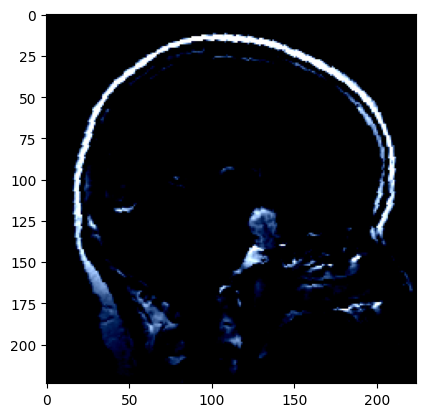

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
plt.imshow(train_features[0].permute(1, 2, 0))

## model

In [11]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

early_stopping = EarlyStopping(tolerance=5, min_delta=10)


class TrainingModel(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        super(TrainingModel, self).__init__()
        vit = fastvit_ma36(pretrained=True, num_classes=n_classes)
        sslmodel = nn.Sequential(*(list(vit.children())[:-1]))
        ckpt = torch.load("/kaggle/working/brain_tumor_moco_model.pth")
        sslmodel.load_state_dict(ckpt["model_parameters"])
        self.model = nn.Sequential(sslmodel, nn.Flatten(), nn.Linear(59584, 16), nn.ReLU(), nn.Linear(16, n_classes))
        
        #self.model = fastvit_ma36(pretrained=True, num_classes=n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = self.forward(data)
            #output = output[:, -1, :]
            loss = criterion(output, target)
            loss.backward()
            
            accuracy = (output.argmax(dim=1) == target).float().mean()
            epoch_loss += loss
            epoch_accuracy += accuracy
            optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            data, target = data.cuda(), target.cuda()
            
            with torch.no_grad():
                output = self.forward(data)
                #output = output[:, -1, :]
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)
    

import gc
def fit_tpu(model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    valid_loss_min = np.Inf  # track change in validation loss

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        #para_train_loader = pl.ParallelLoader(train_loader, [device])

        print(f"{'='*50}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                print("Validation loss decreased ({:.4f} --> {:.4f}). ".format(valid_loss_min, valid_loss))
            #                 xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss
            # early stopping
            early_stopping(train_loss, valid_loss)
            if early_stopping.early_stop:
                print("Early stopping at epoch:", epoch)
                break

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

# model training

In [12]:
from datetime import datetime

model = TrainingModel(n_classes=4)

criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

BATCH_SIZE= 16
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False)

valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False)

start_time = datetime.now()

logs = fit_tpu(
        model=model,
        epochs=20,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
)

print(f"Execution time: {datetime.now() - start_time}")

/tmp/ipykernel_30/1677516962.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/brain_tumor_moco_model.pth")


EPOCH 1 - TRAINING...

	[TRAIN] EPOCH 1 - LOSS: 0.243593230843544, ACCURACY: 0.9164772033691406

EPOCH 1 - VALIDATING...
	[VALID] LOSS: 0.1930036097764969, ACCURACY: 0.9392361044883728

EPOCH 2 - TRAINING...

	[TRAIN] EPOCH 2 - LOSS: 0.08842980861663818, ACCURACY: 0.970061182975769

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 0.07813818007707596, ACCURACY: 0.9730902910232544

Validation loss decreased (0.1930 --> 0.0781). 
EPOCH 3 - TRAINING...

	[TRAIN] EPOCH 3 - LOSS: 0.050720613449811935, ACCURACY: 0.9865384101867676

EPOCH 3 - VALIDATING...
	[VALID] LOSS: 0.11722937226295471, ACCURACY: 0.9644097089767456

EPOCH 4 - TRAINING...

	[TRAIN] EPOCH 4 - LOSS: 0.053604450076818466, ACCURACY: 0.9827359914779663

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 0.07326927781105042, ACCURACY: 0.9765625

Validation loss decreased (0.1172 --> 0.0733). 
EPOCH 5 - TRAINING...

	[TRAIN] EPOCH 5 - LOSS: 0.038007333874702454, ACCURACY: 0.9879807829856873

EPOCH 5 - VALIDATING...
	[VALID] LOSS: 0.06761107593774796,

In [20]:
preds = []
actual = []

tot_loss = tot_acc = count = 0
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=8,
        drop_last=False,
        shuffle=True)
criterion = nn.CrossEntropyLoss(weight=class_weights.cuda())
criterion = criterion.to(device)

for images, labels in test_loader:
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        out_labels = torch.argmax(output, dim=1)
        tot_loss += criterion(output, labels.long().to(device))
        tot_acc += (labels.to(device) == output.argmax(dim=1)).sum()/len(labels)
        count += 1

    preds += output.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

Test Loss: 0.024799933657050133, Test Accuracy: 0.9977133870124817


In [25]:
torch.save(model.state_dict(), "d2_ssl-sefastvit_99.77.pth")

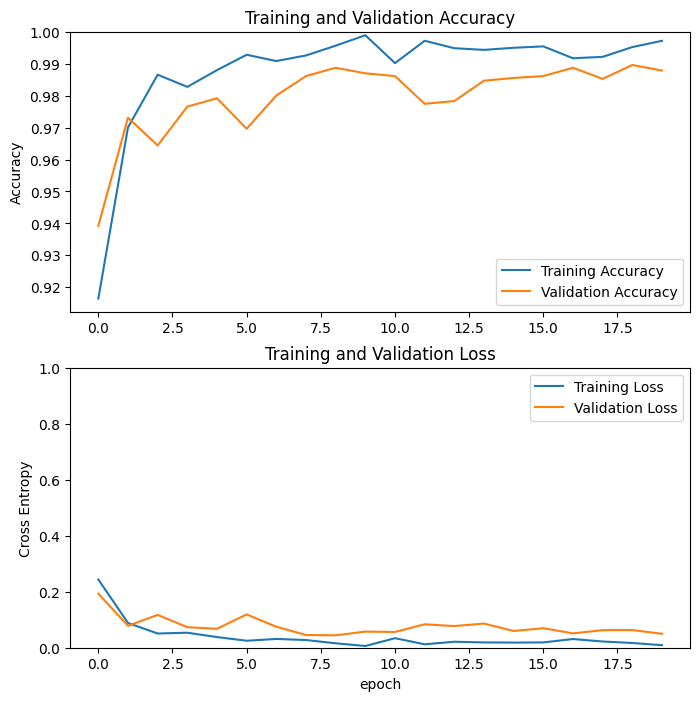

In [21]:
acc = []
for i in logs["train_acc"]:
    acc.append(i.cpu().numpy())

val_acc = []
for i in logs["valid_acc"]:
    val_acc.append(i.cpu().numpy())

loss = []
for i in logs["train_loss"]:
    loss.append(i.cpu().detach().numpy())
    
val_loss = []
for i in logs["valid_losses"]:
    val_loss.append(i.cpu().numpy())
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

predictions = np.argmax(preds, axis=1)

cm = metrics.classification_report(actual, predictions, digits=4)
print(cm)

score = accuracy_score(actual, predictions)
print("Accuracy score: ", score)

              precision    recall  f1-score   support

           0     1.0000    0.9933    0.9967       300
           1     0.9903    1.0000    0.9951       306
           2     1.0000    1.0000    1.0000       405
           3     1.0000    0.9967    0.9983       300

    accuracy                         0.9977      1311
   macro avg     0.9976    0.9975    0.9975      1311
weighted avg     0.9977    0.9977    0.9977      1311

Accuracy score:  0.9977116704805492


['glioma', 'meningioma', 'notumor', 'pituitary']


Text(0.5, 118.72222222222216, 'Predicted')

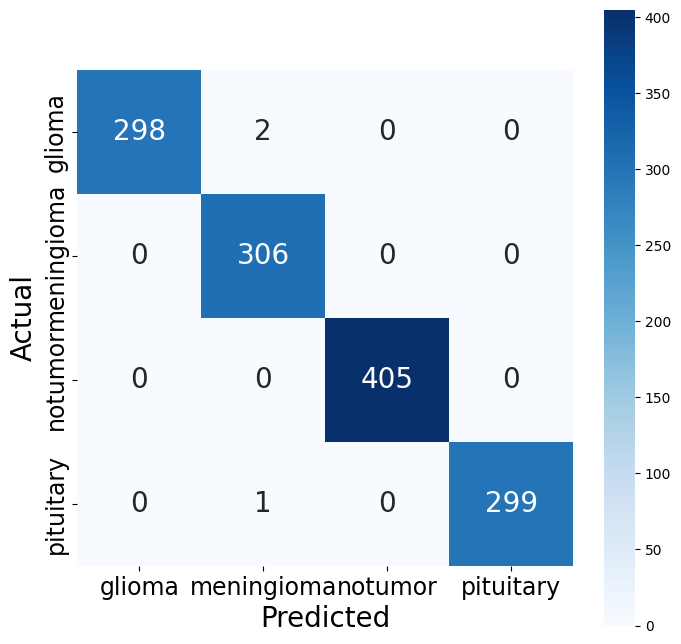

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = dataset.classes
print(class_names)
cm = confusion_matrix(actual, predictions)
"""disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()"""

plt.figure(figsize=(8,8))
ax= sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', annot_kws={"fontsize":20} )
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

0 244
1 478
2 825


(0.0, 1.0, 0.0, 1.0)

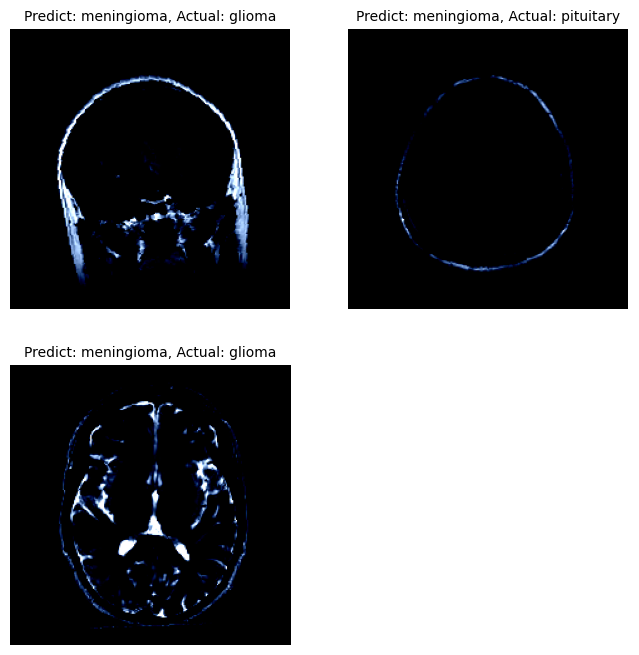

In [24]:
import matplotlib.pyplot as plt
misclassifiedIndexes = np.where(actual!=predictions)[0]

fig, ax = plt.subplots(2, 2,figsize=(8,8))
ax = ax.ravel()
for i, badIndex in enumerate(misclassifiedIndexes):
    print(i, badIndex)
    ax[i].imshow(test_loader.dataset[badIndex][0].permute(1, 2, 0))
    ax[i].set_title(f'Predict: {class_names[predictions[badIndex]]}, '
                    f'Actual: {class_names[actual[badIndex]]}', fontsize = 10)
    ax[i].set(frame_on=False)
    ax[i].axis('off')
plt.box(False)
plt.axis('off')